# Quantized latent with inverse model on continuous maze

## Instanciate and train the model

Create the environment.

In [6]:
import gym
import gym_continuous_maze

env = gym.make("ContinuousMaze-v0")

Initilize the device.

In [7]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [8]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer

buffer = ReplayBuffer(100_000, env.observation_space, env.action_space, device=device)

for episode in range(200):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Instanciate the model and the optimizer.

In [9]:
from go_explore.inverse_model import LinearInverseModel

from torch import optim

inverse_model = LinearInverseModel(obs_size=2, action_size=2, latent_size=2)
optimizer = optim.Adam(inverse_model.parameters(), lr=1e-3)

Train the model.

In [10]:
import torch.nn.functional as F

for epoch in range(5_000):
    # Sample
    sample = buffer.sample(128)
    observations = sample.observations
    next_observations = sample.next_observations
    actions = sample.actions

    # Compute the output image
    inverse_model.train()
    pred_actions = inverse_model(observations, next_observations)

    # Compute the loss
    loss = F.mse_loss(actions, pred_actions)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print("epoch: {:5d}\tprediction loss: {:.5f}".format(epoch, loss.item()))

epoch:     0	prediction loss: 0.37428
epoch:  1000	prediction loss: 0.07782
epoch:  2000	prediction loss: 0.06293
epoch:  3000	prediction loss: 0.08304
epoch:  4000	prediction loss: 0.08584


See the result for one transition.

In [14]:
# Sample one transition
sample = buffer.sample(1)
observations = sample.observations
next_observations = sample.next_observations
actions = sample.actions

# Predict the action
inverse_model.eval()
pred_actions = inverse_model(observations, next_observations)

# See the result
print("observation\t\t", observations)
print("next observation\t", next_observations)
print("true action\t\t", actions)
print("predicted action\t", pred_actions)

observation		 tensor([[0.7652, 3.1950]])
next observation	 tensor([[1.2201, 3.1866]])
true action		 tensor([[ 0.4549, -0.0085]])
predicted action	 tensor([[0.4191, 0.1802]], grad_fn=<AddmmBackward0>)


## Quantizing the latent

Sample and compute the latent.

In [20]:
# Sample a batch of transitions
sample = buffer.sample(512)
observations = sample.observations

# Get the latent and quantized it
inverse_model.eval()
latent = inverse_model.encoder(observations)

Quantize.

In [ ]:
quantized = torch.round(latent, decimals=0) + 0.0  # +0.0 to avoid -0.0
quantized = quantized.detach().cpu().numpy()

Represent the observations and the corresponding quantized latent .

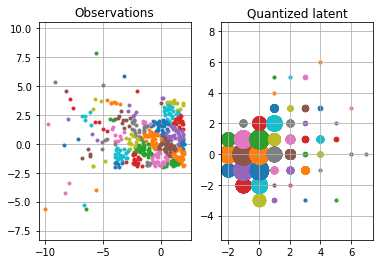

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

cells, counts = np.unique(quantized, return_counts=True, axis=0)

# Observations
axs[0].grid()
axs[0].set_title("Observations")
axs[0].axis("equal")
for cell in cells:
    axs[0].plot(*observations[(quantized == cell).all(1)].T, "o", markersize=3)

# Quantized latent
axs[1].grid()
axs[1].set_title("Quantized latent")
axs[1].axis("equal")
for cell, count in zip(cells, counts):
    axs[1].scatter(*quantized[(quantized == cell).all(1)].T, s=count * 10)

The bigger the circle, the more observations in the cell.